In [ ]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        batch_size,
        img_size,
        seed,
        prepared_img_path,
        n_classes,
        n_inputs=1,
        jpg=True,
        png=False,
        shuffle=False,
        augment=False,
        hard_augment=False,
        trans_aug=False,
        flip_aug=False,
        from_dicom=False,
    ):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.seed = seed
        self.prepared_img_path = prepared_img_path
        self.n_classes = n_classes
        self.n_inputs = n_inputs
        self.jpg = jpg
        self.png = png
        self._shuffle = shuffle
        self.augment = augment
        self.hard_augment = hard_augment
        self.trans_aug = trans_aug
        self.flip_aug = (flip_aug,)
        self.from_dicom = from_dicom

        if not os.path.exists(self.prepared_img_path):
            os.mkdir(self.prepared_img_path)

    def on_epoch_start(self):
        if self._shuffle:
            self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(
                drop=True
            )

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def img_from_dicom(self, img_path, img_type):
        data_file = dicom.dcmread(img_path)
        img = data_file.pixel_array
        if img_type == "MONOCHROME1":
            img = img.max() - img
        img = (img - img.min()) / (img.max() - img.min())
        img = (np.array(img) * 255).astype("uint8")
        img = np.stack([img, img, img], axis=-1)
        img = tf.image.resize(
            img,
            (self.img_size, self.img_size),
        )
        img = tf.cast(img, tf.uint8)
        return img.numpy()

    def make_img(self, img_name, img_path, img_type):
        try:
            img = np.load(self.prepared_img_path + img_name + ".npy")
        except:
            if self.from_dicom:
                img = self.img_from_dicom(img_path, img_type)
            else:
                if self.jpg:
                    img = tf.io.read_file("/app/_data/jpg/" + img_name + ".jpg")
                    img = tf.image.decode_jpeg(img, channels=3)
                elif self.png:
                    img = tf.io.read_file("/app/_data/png/" + img_name + ".png")
                    img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(
                    img,
                    (self.img_size, self.img_size),
                )
                img = tf.cast(img, tf.uint8)
                img = img.numpy()
            np.save(self.prepared_img_path + img_name, img)
        return img

    def _get_one(self, ix):
        img_name = self.df.loc[ix, "image"][:-4]
        img_path = self.df.loc[ix, "path"]
        img_type = self.df.loc[ix, "PhotometricInterpretation"]
        img = self.make_img(img_name, img_path, img_type)
        class_id = self.df.loc[ix, "class"]
        with open("/app/_data/dict_metadata.json", "r") as f:
            dict_metadata = json.load(f)
        if self.augment:
            img = Aug.augment_image(img)
        if self.hard_augment:
            img = Hard_Aug.augment_image(img)
        if self.trans_aug:
            img = Transform_Aug.augment_image(img)
        if self.flip_aug:
            img = Flip_Aug.augment_image(img)
        x, y = {}, {}
        x["img"] = img
        if self.n_inputs == 2:
            modality = self.df.loc[ix, "modality"]
            PatientSex = self.df.loc[ix, "PatientSex"]
            body_part = self.df.loc[ix, "BodyPartExamined"]
            patient_sex_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")
            body_part_x = np.zeros(
                len(dict_metadata["BodyPartExamined"]), dtype="uint8"
            )
            modality_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")

            if PatientSex in dict_metadata["PatientSex"].keys():
                patient_sex_x[dict_metadata["PatientSex"][PatientSex]] = 1
            else:
                patient_sex_x[dict_metadata["PatientSex"]["unknown"]] = 1
            if body_part in dict_metadata["BodyPartExamined"].keys():
                body_part_x[dict_metadata["BodyPartExamined"][body_part]] = 1
            else:
                body_part_x[dict_metadata["BodyPartExamined"]["unknown"]] = 1
            if modality in dict_metadata["modality"].keys():
                modality_x[dict_metadata["modality"][modality]] = 1
            else:
                modality_x[dict_metadata["modality"]["unknown"]] = 1
            x["data"] = np.concatenate([patient_sex_x, body_part_x, modality_x])
        else:
            x["data"] = 0
        if self.n_classes == 4:
            y_ = np.zeros(4, dtype="uint8")
            y_[dict_metadata["class"][class_id]] = 1
        elif self.n_classes == 1:
            if class_id == "negative":
                y_ = 1
            else:
                y_ = 0
        y["output"] = y_

        return x, y

    def __getitem__(self, batch_ix):
        x, y = {}, {}
        b_x_img, b_x_data, b_y = [], [], []
        for i in range(self.batch_size):
            x_dict, y_dict = self._get_one(i + self.batch_size * batch_ix)
            b_x_img.append(x_dict["img"])
            b_x_data.append(x_dict["data"])
            b_y.append(y_dict["output"])
        x["img"] = np.array(b_x_img)
        x["data"] = np.array(b_x_data)
        y["output"] = np.array(b_y)
        return x, y

In [ ]:
class Test:
    def make_classification(
        test_df_,
        model_path,
        model_2cl_path,
        generator,
        obj_det=True,
        classification=True,
    ):
        sub_study = pd.DataFrame(columns=["id", "PredictionString"])
        labels = ["negative", "typical", "indeterminate", "atypical"]
        # check only object detection score
        if not classification:
            for ix in test_df_.StudyInstanceUID.unique().tolist():
                sub_study = sub_study.append(
                    {
                        "id": ix + "_study",
                        "PredictionString": "negative 1 0 0 1 1 typical 1 0 0 1 1 indeterminate 1 0 0 1 1 atypical 1 0 0 1 1",
                    },
                    ignore_index=True,
                )
        # classification 4 classes: "negative", "typical", "indeterminate", "atypical"
        else:
            eff_models = []
            for m_path in model_path:
                if ".h5" in m_path:
                    eff_models.append(keras.models.load_model(m_path))
                else:
                    for file in os.listdir(m_path):
                        if ".h5" in file:
                            eff_models.append(keras.models.load_model(m_path + file))
            # classification 2 classes: "negative", "positive"
            if model_2cl_path is not None:
                models_2cl = []
                for m_path in model_2cl_path:
                    models_2cl.append(keras.models.load_model(m_path))

            for ix in tqdm(test_df_.index.tolist()):
                data = generator.__getitem__(ix)
                pred = np.mean([model.predict(data)[0] for model in eff_models], axis=0)
                test_df_.loc[ix, "negative"] = pred[0]
                test_df_.loc[ix, "typical"] = pred[1]
                test_df_.loc[ix, "indeterminate"] = pred[2]
                test_df_.loc[ix, "atypical"] = pred[3]
                if model_2cl_path is not None:
                    pred_neg = np.mean([m.predict(data)[0][0] for m in models_2cl])
                    test_df_.loc[ix, "negative_2cl"] = pred_neg
            # PredictionString in format 'label threshold 0 0 1 1'
            groupped_df = test_df_.groupby("StudyInstanceUID")[
                ["negative", "typical", "indeterminate", "atypical"]
            ].mean()
            for ix in groupped_df.index.tolist():
                predictions = list(map(str, (np.round(groupped_df.loc[ix].values, 8))))
                pred = " ".join(
                    [
                        labels[i] + " " + predictions[i] + " 0 0 1 1"
                        for i in range(len(labels))
                    ]
                )
                sub_study = sub_study.append(
                    {"id": ix + "_study", "PredictionString": pred}, ignore_index=True
                )

        # check only classification score
        if not obj_det:
            sub_image = pd.DataFrame(columns=["id", "PredictionString"])
            for img_name in test_df_.id_image.tolist():
                sub_image = sub_image.append(
                    {"id": img_name + "_image", "PredictionString": "none 1 0 0 1 1"},
                    ignore_index=True,
                )
            return sub_study, sub_image, test_df_
        return sub_study, test_df_

In [1]:
import ast
import json
import os
import shutil

import albumentations
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import tensorflow_addons as tfa
import torch
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from tensorflow import keras
from tqdm import tqdm

from src.augment import Aug, Flip_Aug, Hard_Aug, Transform_Aug

InteractiveShell.ast_node_interactivity = "all"

In [2]:
with open("/app/_data/base_config.json", "r") as f:
    base_config = json.load(f)
base_config

{'EFFB7': {'IMG_SIZE': 600,
  'BATCH_SIZE': 4,
  'SEED': 42,
  'WEIGHTS': '/app/_data/noisy-student-efficientnet-b7/efficientnetb7_notop.h5'},
 'CLASS': {'negative': 0, 'typical': 1, 'indeterminate': 2, 'atypical': 3},
 'EFFB4': {'IMG_SIZE': 380,
  'BATCH_SIZE': 50,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b4_noisy-student_notop.h5'}}

In [3]:
# file_json = open("/app/_data/base_config.json", "w")
# json.dump(base_config, file_json)
# file_json.close()

In [4]:
list_bad = [
    "f00655c68e05.jpg",
    "b6f989cfd190.jpg",
    "5cae48f87eb1.jpg",
    "f5af0ed4c2db.jpg",
    "57675376af04.jpg",
    "0c22dc834dea.jpg",
]

In [5]:
train = pd.read_csv("/app/_data/train.csv")

In [6]:
# os.mkdir("/app/_data/train_npy/")

In [7]:
train["class_id"] = train["class"].replace(base_config["CLASS"])

In [8]:
list_wrong = train[
    (train["class"] != "negative") & (train["label"] == "none 1 0 0 1 1")
]["id_image"].tolist()
train = train.query("id_image not in @list_wrong").reset_index(drop=True)

In [9]:
train

,id_image,boxes,label,StudyInstanceUID,image,id_study,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,...,PhotometricInterpretation,Rows,Columns,width,height,n_bbox,modality_id,p_sex,body_part_id,class_id
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2.dcm,5776db0cec75_study,0,1,0,0,...,MONOCHROME2,3488.0,4256.0,4256.0,3488.0,2,1,1,2,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f.dcm,ff0879eb20ed_study,1,0,0,0,...,MONOCHROME2,2320.0,2832.0,2832.0,2320.0,0,0,1,2,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc.dcm,9d514ce429a7_study,0,1,0,0,...,MONOCHROME2,2544.0,3056.0,3056.0,2544.0,2,1,0,4,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f.dcm,28dddc8559b2_study,0,0,0,1,...,MONOCHROME1,3520.0,4280.0,4280.0,3520.0,1,0,0,2,3
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891.dcm,dfd9fdd85a3e_study,0,1,0,0,...,MONOCHROME1,2800.0,3408.0,3408.0,2800.0,2,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,ffcc6edd9445.dcm,7e6c68462e06_study,1,0,0,0,...,MONOCHROME2,4240.0,3480.0,3480.0,4240.0,0,0,0,2,0
6026,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,ffd91a2c4ca0.dcm,8332bdaddb6e_study,1,0,0,0,...,MONOCHROME1,2800.0,3408.0,3408.0,2800.0,0,1,0,2,0
6027,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,ffd9b6cf2961.dcm,7eed9af03814_study,0,1,0,0,...,MONOCHROME2,2388.0,3050.0,3050.0,2388.0,3,1,1,9,1
6028,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,ffdc682f7680.dcm,a0cb0b96fb3d_study,0,1,0,0,...,MONOCHROME2,3488.0,4256.0,4256.0,3488.0,2,1,1,2,1


In [10]:
class Hard_Aug:
    def augment_image(img):
        h = img.shape[0]
        w = img.shape[1]
        transform = albumentations.Compose(
            [
                albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
                albumentations.OneOf(
                    [
                        albumentations.MotionBlur((3, 5)),
                        albumentations.MedianBlur(blur_limit=5),
                        albumentations.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                        albumentations.Blur(blur_limit=(3, 5)),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.GaussNoise(var_limit=[10, 20], mean=1),
                        albumentations.ImageCompression(
                            quality_lower=70, quality_upper=100, compression_type=1
                        ),
                        albumentations.MultiplicativeNoise(
                            multiplier=(0.95, 1.05), per_channel=False, elementwise=True
                        ),
                        albumentations.Downscale(
                            scale_min=0.8,
                            scale_max=0.99,
                            interpolation=cv2.INTER_LINEAR,
                        ),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.RandomBrightnessContrast(
                            brightness_limit=0.2,
                            contrast_limit=0.2,
                            brightness_by_max=True,
                        ),
                        albumentations.augmentations.transforms.Sharpen(
                            alpha=(0.05, 0.15), lightness=(0.5, 1.0), p=1
                        ),
                        albumentations.augmentations.transforms.RandomToneCurve(
                            scale=0.15
                        ),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.OpticalDistortion(
                            distort_limit=0.3,
                            shift_limit=0.9,
                            border_mode=0,
                        ),
                        albumentations.ElasticTransform(
                            alpha=5.0,
                            sigma=50.0,
                            alpha_affine=7.0,
                            interpolation=cv2.INTER_LINEAR,
                            border_mode=0,
                        ),
                        albumentations.GridDistortion(
                            num_steps=5,
                            distort_limit=0.3,
                            interpolation=cv2.INTER_LINEAR,
                            border_mode=0,
                        ),
                        albumentations.Rotate(
                            limit=(-360, 360),
                            interpolation=cv2.INTER_LINEAR,
                            border_mode=0,
                        ),
                        albumentations.ShiftScaleRotate(
                            shift_limit=0.2,
                            scale_limit=0.2,
                            rotate_limit=360,
                            interpolation=cv2.INTER_LINEAR,
                            border_mode=0,
                        ),
                        albumentations.augmentations.crops.transforms.CropAndPad(
                            px=None,
                            percent=(-0.3, 0.2),
                            pad_mode=0,
                            pad_cval=0,
                            pad_cval_mask=0,
                            keep_size=True,
                            sample_independently=True,
                            interpolation=cv2.INTER_LINEAR,
                        ),
                        albumentations.RandomSizedCrop(
                            min_max_height=(0.8 * h, 0.85 * w),
                            height=h,
                            width=w,
                            w2h_ratio=1.0,
                            interpolation=cv2.INTER_LINEAR,
                        ),
                    ],
                    p=0.3,
                ),
                albumentations.OneOf(
                    [
                        albumentations.HorizontalFlip(),
                        albumentations.VerticalFlip(),
                        albumentations.RandomRotate90(),
                        albumentations.Flip(),
                    ],
                    p=0.1,
                ),
            ]
        )

        return transform(image=img)["image"]

In [69]:
train[
    [
        "id_image",
        "boxes",
        "StudyInstanceUID",
        "image",
        "class",
        "path",
        "modality",
        "PatientSex",
        "BodyPartExamined",
        "PhotometricInterpretation",
        "width",
        "height",
        "n_bbox",
        "class_id",
    ]
]

,id_image,boxes,StudyInstanceUID,image,class,path,modality,PatientSex,BodyPartExamined,PhotometricInterpretation,width,height,n_bbox,class_id
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,000a312787f2.dcm,typical,/app/_data/train/5776db0cec75/81456c9c5423/000...,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,2,1
1,000c3a3f293f_image,NaN,ff0879eb20ed,000c3a3f293f.dcm,negative,/app/_data/train/ff0879eb20ed/d8a644cc4f93/000...,CR,M,CHEST,MONOCHROME2,2832.0,2320.0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,0012ff7358bc.dcm,typical,/app/_data/train/9d514ce429a7/22897cd1daa0/001...,DX,F,PORT CHEST,MONOCHROME2,3056.0,2544.0,2,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,001398f4ff4f.dcm,atypical,/app/_data/train/28dddc8559b2/4d47bc042ee6/001...,CR,F,CHEST,MONOCHROME1,4280.0,3520.0,1,3
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,001bd15d1891.dcm,typical,/app/_data/train/dfd9fdd85a3e/49170afa4f27/001...,DX,M,CHEST,MONOCHROME1,3408.0,2800.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,ffcc6edd9445_image,NaN,7e6c68462e06,ffcc6edd9445.dcm,negative,/app/_data/train/7e6c68462e06/98011bca5fd2/ffc...,CR,F,CHEST,MONOCHROME2,3480.0,4240.0,0,0
6026,ffd91a2c4ca0_image,NaN,8332bdaddb6e,ffd91a2c4ca0.dcm,negative,/app/_data/train/8332bdaddb6e/f346cda52da0/ffd...,DX,F,CHEST,MONOCHROME1,3408.0,2800.0,0,0
6027,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",7eed9af03814,ffd9b6cf2961.dcm,typical,/app/_data/train/7eed9af03814/668a64e3a5fa/ffd...,DX,M,TORAX,MONOCHROME2,3050.0,2388.0,3,1
6028,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",a0cb0b96fb3d,ffdc682f7680.dcm,typical,/app/_data/train/a0cb0b96fb3d/ccf363aa080f/ffd...,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,2,1


In [70]:
with open("/app/src/dict_metadata.json", "r") as f:
    dict_metadata = json.load(f)

In [9]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        batch_size,
        img_size,
        seed,
        prepared_img_path,
        n_inputs=1,
        shuffle=False,
        augment=False,
    ):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.seed = seed
        self.prepared_img_path = prepared_img_path
        self._shuffle = shuffle
        self.augment = augment
        self.n_inputs = n_inputs

        if not os.path.exists(self.prepared_img_path):
            os.mkdir(self.prepared_img_path)

    def on_epoch_start(self):
        if self._shuffle:
            self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(
                drop=True
            )

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def make_img(self, img_name):
        try:
            img = np.load(self.prepared_img_path + img_name + ".npy")
        except:
            img = tf.io.read_file("/app/_data/jpg/" + img_name + ".jpg")
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(
                img,
                (self.img_size, self.img_size),
            )
            img = tf.cast(img, tf.uint8)
            img = img.numpy()
            np.save(self.prepared_img_path + img_name, img)
        return img

    def _get_one(self, ix):
        img_name = self.df.loc[ix, "image"][:-4]
        img = self.make_img(img_name)
        class_id = self.df.loc[ix, "class"]
        with open("/app/_data/dict_metadata.json", "r") as f:
            dict_metadata = json.load(f)
        if self.augment:
            img = Aug.augment_image(img)
        if self.n_inputs == 1:
            x = img
        elif self.n_inputs == 2:
            modality = self.df.loc[ix, "modality"]
            PatientSex = self.df.loc[ix, "PatientSex"]
            body_part = self.df.loc[ix, "BodyPartExamined"]
            x = {}

            patient_sex_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")
            body_part_x = np.zeros(
                len(dict_metadata["BodyPartExamined"]), dtype="uint8"
            )
            modality_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")

            if PatientSex in dict_metadata["PatientSex"].keys():
                patient_sex_x[dict_metadata["PatientSex"][PatientSex]] = 1
            else:
                patient_sex_x[dict_metadata["PatientSex"]["unknown"]] = 1
            if body_part in dict_metadata["BodyPartExamined"].keys():
                body_part_x[dict_metadata["BodyPartExamined"][body_part]] = 1
            else:
                body_part_x[dict_metadata["BodyPartExamined"]["unknown"]] = 1
            if modality in dict_metadata["modality"].keys():
                modality_x[dict_metadata["modality"][modality]] = 1
            else:
                modality_x[dict_metadata["modality"]["unknown"]] = 1
            x["img"] = img
            x["data"] = np.concatenate([patient_sex_x, body_part_x, modality_x])

        y = np.zeros(4, dtype="uint8")
        y[dict_metadata["class"][class_id]] = 1
        return x, y

    def __getitem__(self, batch_ix):

        if self.n_inputs == 1:
            x, y = [], []
            for i in range(self.batch_size):
                x_, y_ = self._get_one(i + self.batch_size * batch_ix)
                x.append(x_)
                y.append(y_)
            y = np.array(y)
            x = np.array(x)

        elif self.n_inputs == 2:
            x, y = {}, []
            b_x_img = []
            b_x_data = []
            for i in range(self.batch_size):
                x_dict, y_ = self._get_one(i + self.batch_size * batch_ix)
                b_x_img.append(x_dict["img"])
                b_x_data.append(x_dict["data"])
                y.append(y_)
            x["img"] = np.array(b_x_img)
            x["data"] = np.array(b_x_data)
            y = np.array(y)

        return x, y

In [ ]:
img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

In [17]:
for img_name in train.sample(40)["image"].tolist():
    img = tf.io.read_file("/app/_data/jpg/" + img_name[:-4] + ".jpg")
    img = tf.image.decode_jpeg(img, channels=3)
    img1 = tf.cast(img, tf.float32) / 255.0

    img1 = (
        tf.image.resize(
            img1,
            (600, 600),
        )
        * 255
    )
    img1 = tf.cast(img1, tf.uint8)
    img1 = img1.numpy()
    img = tf.image.resize(
        img,
        (600, 600),
    )
    img = tf.cast(img, tf.uint8)
    img = np.array(img)
    print("tf:", img1.min(), img1.max(), "pil:", img.min(), img.max())

tf: 0 250 pil: 0 250
tf: 0 255 pil: 0 255
tf: 0 208 pil: 0 208
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 247 pil: 0 247
tf: 0 250 pil: 0 250
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 251 pil: 0 251
tf: 0 255 pil: 0 255
tf: 0 236 pil: 0 236
tf: 0 255 pil: 0 255
tf: 0 252 pil: 0 252
tf: 0 253 pil: 0 253
tf: 0 255 pil: 0 255
tf: 0 252 pil: 0 252
tf: 0 252 pil: 0 252
tf: 0 255 pil: 0 255
tf: 0 229 pil: 0 229
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 182 pil: 0 182
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 243 pil: 0 243
tf: 0 254 pil: 0 254
tf: 0 254 pil: 0 254
tf: 0 219 pil: 0 219
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 255 pil: 0 255
tf: 0 253 pil: 0 253
tf: 0 255 pil: 0 255
tf: 0 254 pil: 0 254
tf: 0 255 pil: 0 255


In [13]:
class GetModel1:
    def __init__(
        self,
        model_name,
        n_classes=4,
        n_inputs=2,
        lr=0.0005,
        top_dropout_rate=0.1,
        activation_func="softmax",
        weights=None,
        loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    ):
        self.model_name = model_name
        self.n_inputs = n_inputs
        self.lr = lr
        self.activation_func = activation_func
        self.weights = weights
        self.n_classes = n_classes
        self.top_dropout_rate = top_dropout_rate
        self.loss = loss

    def get_model(self):
        model_name = self.model_name
        with open("/app/_data/base_config.json", "r") as f:
            base_config = json.load(f)

        IMG_SIZE = base_config[model_name]["IMG_SIZE"]

        if model_name == "EFFB7":
            base_model = keras.applications.EfficientNetB7(
                weights=self.weights, include_top=False
            )
        elif model_name == "EFFB4":
            base_model = keras.applications.EfficientNetB4(
                weights=self.weights, include_top=False
            )
        # img input
        input_img = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="img")
        x_img = base_model(input_img)
        x_img = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x_img)
        x_img = keras.layers.BatchNormalization()(x_img)
        if self.top_dropout_rate is not None:
            x_img = keras.layers.Dropout(self.top_dropout_rate, name="top_dropout")(
                x_img
            )
        # data input
        if self.n_inputs == 2:
            input_data = keras.Input(shape=18, name="data")
            x_data = keras.layers.Dense(32, activation="relu", name="dense_data_1")(
                input_data
            )
            x_data = keras.layers.Dense(32, activation="relu", name="dense_data_2")(
                x_data
            )
            x_data = keras.layers.Dense(32, activation="relu", name="dense_data_3")(
                x_data
            )
            x = keras.layers.Concatenate(axis=1, name="all")(
                [
                    x_img,
                    x_data,
                ]
            )
            inputs = [input_img, input_data]
        else:
            x = x_img
            inputs = input_img
        output = keras.layers.Dense(
            self.n_classes,
            activation=self.activation_func,
            dtype="float32",
            name="output",
        )(x)
        model = keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=self.loss,
            optimizer=keras.optimizers.Adam(lr=self.lr),
            metrics=["acc", keras.metrics.AUC(multi_label=True)],
        )
        return model

In [17]:
m = GetModel(
    model_name="EFFB7",
    n_classes=4,
    n_inputs=1,
    lr=0.0005,
    top_dropout_rate=0.1,
    activation_func="softmax",
    weights="/app/_data/noisy-student-efficientnet-b7/efficientnetb7_notop.h5",
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
)

In [18]:
model = m.get_model()

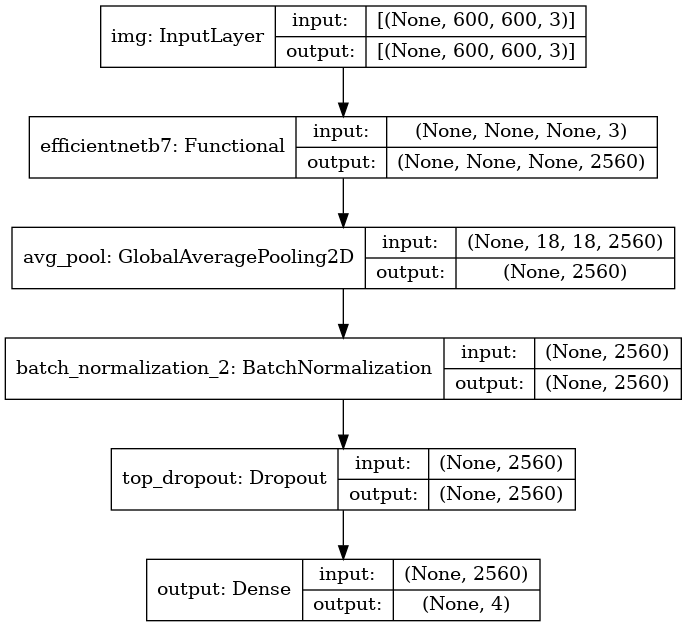

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
input_img = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="img")

In [ ]:
loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},

In [33]:
img1.numpy().max()

254

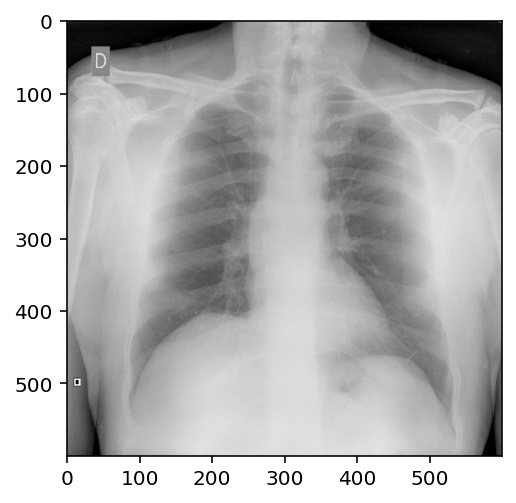

In [55]:
plt.imshow(img1)

In [57]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical"
        ),
        keras.layers.experimental.preprocessing.RandomRotation(
            factor=1.0,
            fill_mode="constant",
            interpolation="bilinear",
            fill_value=0,
        ),
    ]
)

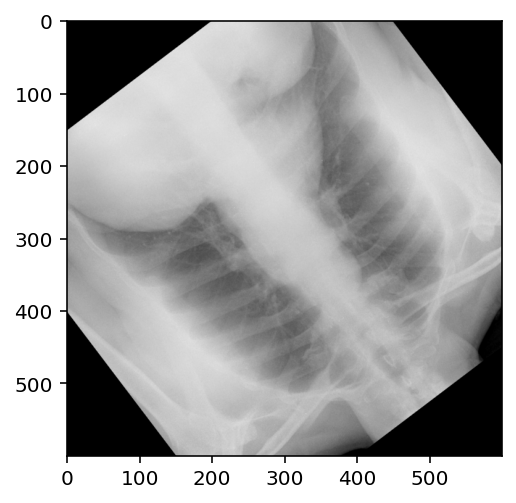

In [71]:
a = data_augmentation(tf.expand_dims(img1, axis=0, name=None))
plt.imshow(a[0])

In [96]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        batch_size,
        img_size,
        seed,
        prepared_img_path,
        n_classes,
        n_inputs=1,
        jpg=False,
        png=True,
        shuffle=False,
        augment=False,
        hard_augment=False,
        trans_aug=False,
        flip_aug=False,
    ):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.seed = seed
        self.prepared_img_path = prepared_img_path
        self.n_classes = n_classes
        self.n_inputs = n_inputs
        self.jpg = jpg
        self.png = png
        self._shuffle = shuffle
        self.augment = augment
        self.hard_augment = hard_augment
        self.trans_aug = trans_aug
        self.flip_aug = (flip_aug,)

        if not os.path.exists(self.prepared_img_path):
            os.mkdir(self.prepared_img_path)

    def on_epoch_start(self):
        if self._shuffle:
            self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(
                drop=True
            )

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def make_img(self, img_name):
        try:
            img = np.load(self.prepared_img_path + img_name + ".npy")
        except:
            if self.jpg:
                img = tf.io.read_file("/app/_data/jpg/" + img_name + ".jpg")
                img = tf.image.decode_jpeg(img, channels=3)
            elif self.png:
                img = tf.io.read_file("/app/_data/png/" + img_name + ".png")
                img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(
                img,
                (self.img_size, self.img_size),
            )
            img = tf.cast(img, tf.uint8)
            img = img.numpy()
            np.save(self.prepared_img_path + img_name, img)
        return img

    def _get_one(self, ix):
        img_name = self.df.loc[ix, "image"][:-4]
        img = self.make_img(img_name)
        class_id = self.df.loc[ix, "class"]
        with open("/app/_data/dict_metadata.json", "r") as f:
            dict_metadata = json.load(f)
        if self.augment:
            img = Aug.augment_image(img)
        if self.hard_augment:
            img = Hard_Aug.augment_image(img)
        if self.trans_aug:
            img = Transform_Aug.augment_image(img)
        if self.flip_aug:
            img = Flip_Aug.augment_image(img)
        x, y = {}, {}
        x["img"] = img
        if self.n_inputs == 2:
            modality = self.df.loc[ix, "modality"]
            PatientSex = self.df.loc[ix, "PatientSex"]
            body_part = self.df.loc[ix, "BodyPartExamined"]
            patient_sex_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")
            body_part_x = np.zeros(
                len(dict_metadata["BodyPartExamined"]), dtype="uint8"
            )
            modality_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")

            if PatientSex in dict_metadata["PatientSex"].keys():
                patient_sex_x[dict_metadata["PatientSex"][PatientSex]] = 1
            else:
                patient_sex_x[dict_metadata["PatientSex"]["unknown"]] = 1
            if body_part in dict_metadata["BodyPartExamined"].keys():
                body_part_x[dict_metadata["BodyPartExamined"][body_part]] = 1
            else:
                body_part_x[dict_metadata["BodyPartExamined"]["unknown"]] = 1
            if modality in dict_metadata["modality"].keys():
                modality_x[dict_metadata["modality"][modality]] = 1
            else:
                modality_x[dict_metadata["modality"]["unknown"]] = 1
            x["data"] = np.concatenate([patient_sex_x, body_part_x, modality_x])

        y1 = np.zeros(4, dtype="uint8")
        y1[dict_metadata["class"][class_id]] = 1
        y["output1"] = y1
        if class_id == "negative":
            y2 = 1
        else:
            y2 = 0
        y["output2"] = y2
        return x, y

    def __getitem__(self, batch_ix):
        x, y = {}, {}
        b_x_img, b_x_data = [], []
        b_y_1, b_y_2 = [], []
        for i in range(self.batch_size):
            x_dict, y_dict = self._get_one(i + self.batch_size * batch_ix)
            b_x_img.append(x_dict["img"])
            b_x_data.append(x_dict["data"])
            b_y_1.append(y_dict["output1"])
            b_y_2.append(y_dict["output2"])
        x["img"] = np.array(b_x_img)
        x["data"] = np.array(b_x_data)
        y["output1"] = np.array(b_y_1)
        y["output2"] = np.array(b_y_2)

        return x, y

In [101]:
gen = Generator(
    df=train,
    prepared_img_path="/app/_data/train_tmp/",
    batch_size=base_config["EFFB7"]["BATCH_SIZE"],
    img_size=base_config["EFFB7"]["IMG_SIZE"],
    seed=base_config["EFFB7"]["SEED"],
    shuffle=True,
    augment=False,
    n_inputs=2,
    jpg=True,
    png=False,
    n_classes=4,
)

In [102]:
a, b = gen._get_one(77)

In [103]:
a
b

{'img': array([[[54, 54, 54],
         [56, 56, 56],
         [57, 57, 57],
         ...,
         [57, 57, 57],
         [56, 56, 56],
         [54, 54, 54]],
 
        [[56, 56, 56],
         [57, 57, 57],
         [59, 59, 59],
         ...,
         [59, 59, 59],
         [61, 61, 61],
         [54, 54, 54]],
 
        [[56, 56, 56],
         [59, 59, 59],
         [59, 59, 59],
         ...,
         [60, 60, 60],
         [61, 61, 61],
         [56, 56, 56]],
 
        ...,
 
        [[35, 35, 35],
         [35, 35, 35],
         [39, 39, 39],
         ...,
         [54, 54, 54],
         [52, 52, 52],
         [51, 51, 51]],
 
        [[34, 34, 34],
         [36, 36, 36],
         [34, 34, 34],
         ...,
         [56, 56, 56],
         [53, 53, 53],
         [51, 51, 51]],
 
        [[42, 42, 42],
         [40, 40, 40],
         [36, 36, 36],
         ...,
         [58, 58, 58],
         [49, 49, 49],
         [50, 50, 50]]], dtype=uint8),
 'data': array([1, 0, 0, 0, 0, 1, 0

{'output1': array([1, 0, 0, 0], dtype=uint8), 'output2': 1}

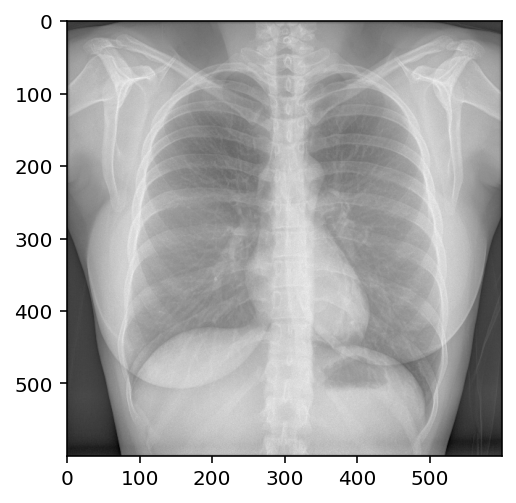

In [104]:
plt.imshow(a["img"])

In [86]:
a.shape

(600, 600, 3)

In [105]:
a, b = gen.__getitem__(54)

In [109]:
a["img"].shape
a["data"].shape

(16, 600, 600, 3)

(16, 18)

In [111]:
b["output1"].shape
b["output2"].shape

(16, 4)

(16,)

In [89]:
a[1].shape

(600, 600, 3)

In [94]:
a[2].max()

221

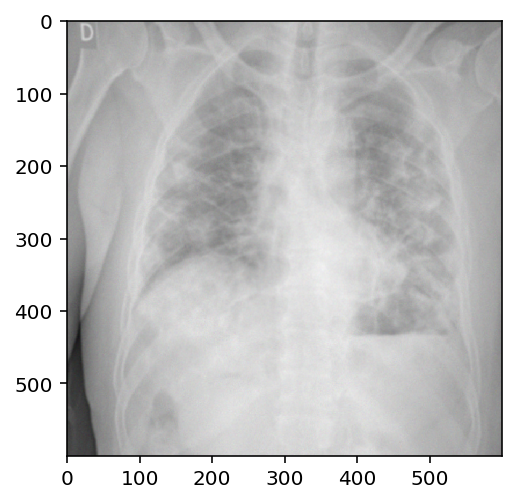

In [81]:
plt.imshow(a[3])

In [84]:
# shutil.rmtree("/app/_data/train_jpg_600")

In [110]:
c = Get_Model.make_callback(
    model_path="/app/_data/models/EffB7_init/",
    tensorboard_path="/app/.tensorboard/EffB7_init_0",
    patience_ES=12,
    patience_RLR=5,
    factor_LR=0.9,
    metric_for_monitor="val_loss",
    metric_mode="min",
)

Warning! Model path already exists.


In [109]:
c

In [56]:
base_config

{'EFFB7': {'IMG_SIZE': 600,
  'BATCH_SIZE': 16,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b7_noisy-student_notop.h5'},
 'CLASS': {'negative': 0, 'typical': 1, 'indeterminate': 2, 'atypical': 3}}

In [12]:
dict_metadata

{'modality': {'CR': 0, 'DX': 1, 'unknown': 2},
 'PatientSex': {'F': 0, 'M': 1, 'unknown': 2},
 'BodyPartExamined': {'2- TORAX': 0,
  'ABDOMEN': 1,
  'CHEST': 2,
  'PECHO': 3,
  'PORT CHEST': 4,
  'Pecho': 5,
  'SKULL': 6,
  'T?RAX': 7,
  'THORAX': 8,
  'TORAX': 9,
  'TÒRAX': 10,
  'unknown': 11}}

In [75]:
from src.utils import Aug, Generator, GetModel

In [76]:
base_config

{'EFFB7': {'IMG_SIZE': 600,
  'BATCH_SIZE': 16,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b7_noisy-student_notop.h5'},
 'CLASS': {'negative': 0, 'typical': 1, 'indeterminate': 2, 'atypical': 3}}

In [77]:
gen = Generator(
    df=train,
    batch_size=base_config["EFFB7"]["BATCH_SIZE"],
    seed=base_config["EFFB7"]["SEED"],
    img_size=base_config["EFFB7"]["IMG_SIZE"],
    prepared_img_path="/app/_data/train_jpg_600/",
    shuffle=True,
    augment=True,
)

In [84]:
a = gen.__getitem__(11)

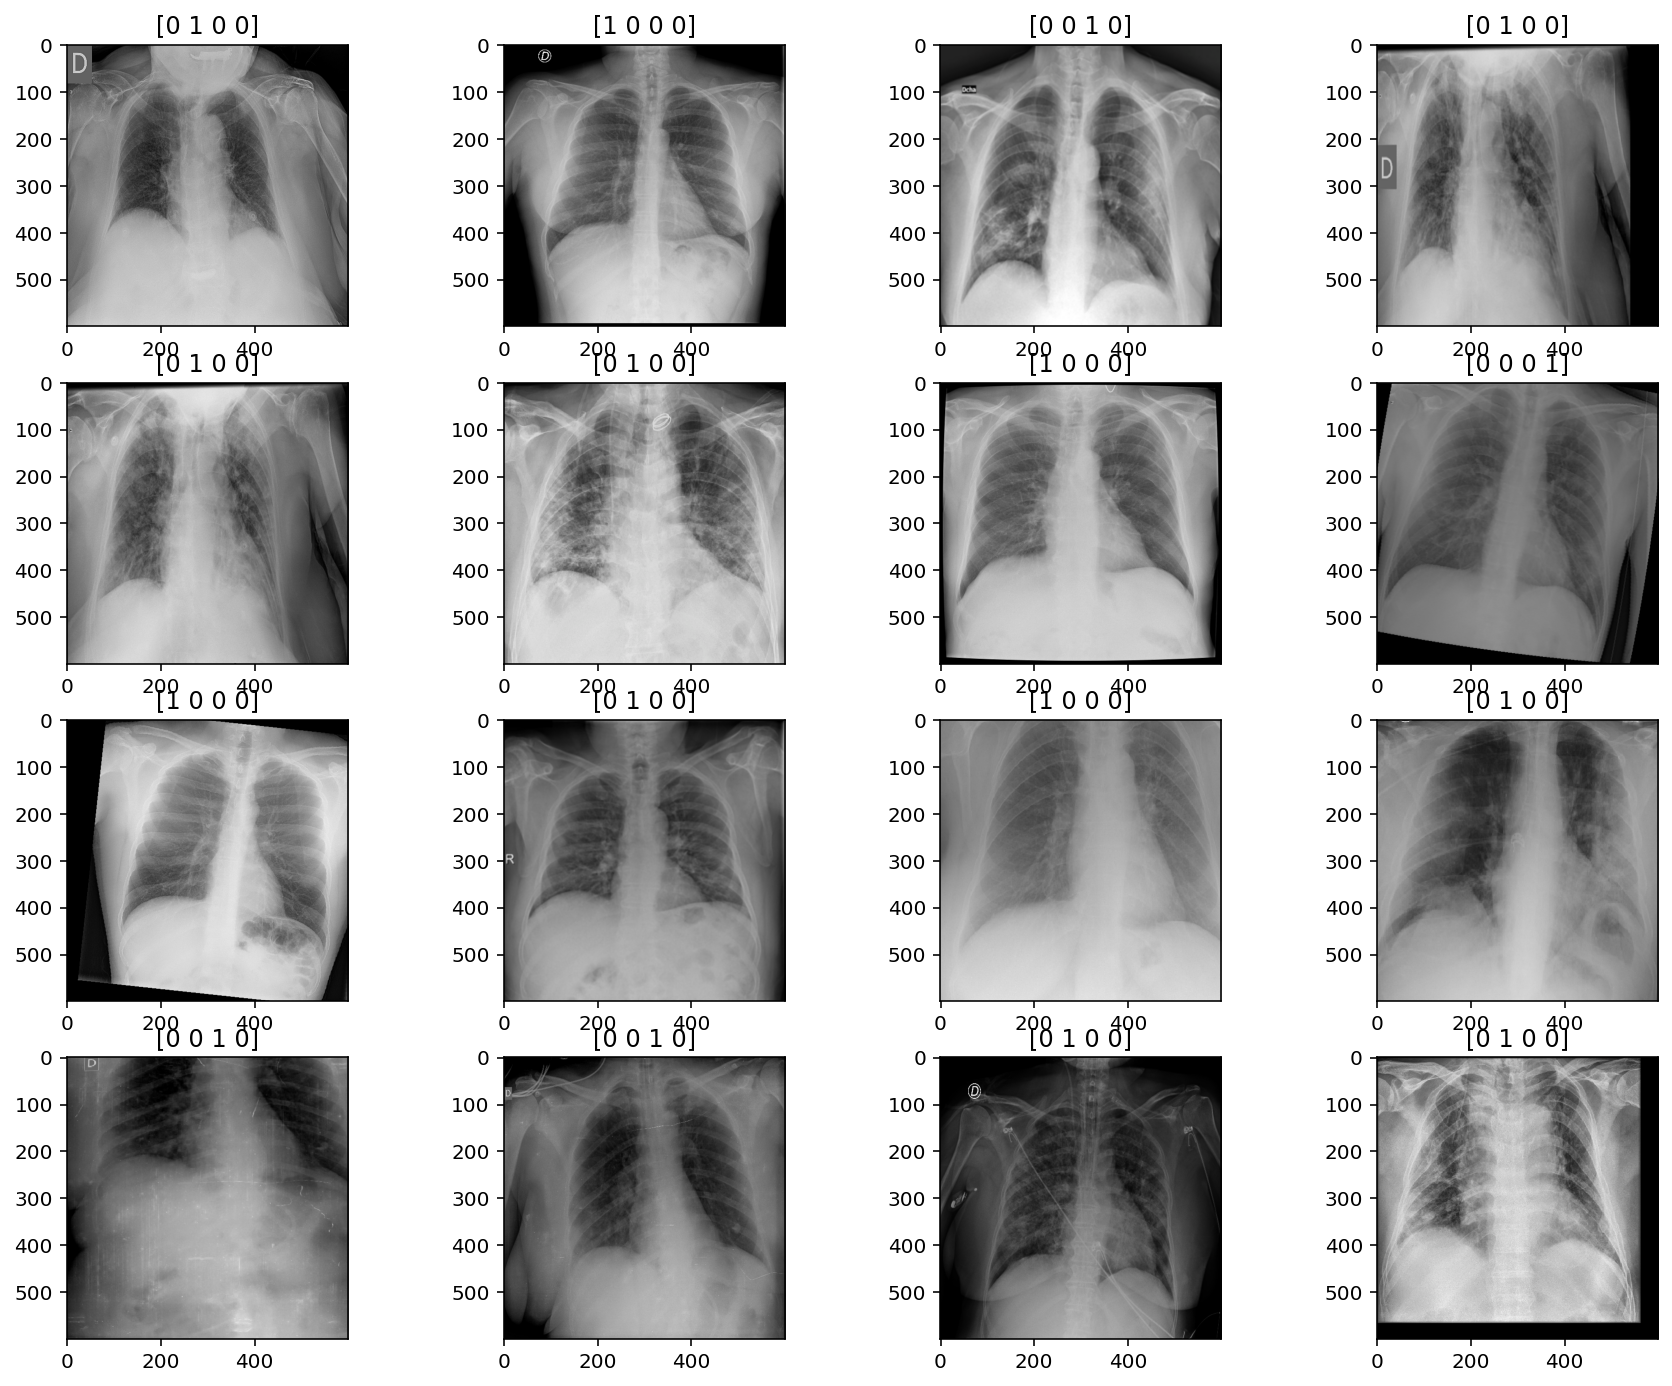

In [85]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(5, 4, i + 1)
    plt.title(a[1][i])
    plt.imshow(a[0]["img"][i])